In [10]:
%matplotlib inline
import autograd.numpy as np
import pylab as plt
import matplotlib.colors as colors
import seaborn as snb

from autograd.scipy.stats import norm

from exercise5 import compute_err
from exercise5 import eval_density_grid
from exercise5 import load_MNIST_subset
from exercise5 import generate_samples
from exercise5 import plot_with_uncertainty
from exercise5 import add_colorbar

from exercise5 import GaussianProcessModel
from exercise5 import NeuralNetworkMAP

snb.set_style('darkgrid')
snb.set(font_scale=1.5)


# 02477 Bayesian Machine Learning: Non-Gaussian likelihoods and Gaussian processes classification

The purpose of this exercise is to
- get familiar with Bayesian modelling with non-Gaussian likelihoods
- study Gaussian processes for binary classification
- understand how to compute predictive distributions for Monte Carlo methods

The exercise is divided into two parts:
- Part 1: Gaussian process classification for 1D toy data
- Part 2: Gaussian process classification for 2D data set

### Part 1: Gaussian process classification

In the first part, we will study Gaussian processes for binary classification using the following model

$$\begin{align*}
t|y(\mathbf{x}) &\sim \text{Ber}[\sigma(y(\mathbf{x}))]\\
y(\mathbf{x}) &\sim \mathcal{GP}(0, k(\mathbf{x}, \mathbf{x}')),
\end{align*}$$

where $k(\mathbf{x}, \mathbf{x}')$ is the covariance function and $\sigma: \mathbb{R} \rightarrow (0, 1)$ is a suitable (inverse) link function. Here we will use the logistic sigmoid function. The purpose of the function $\sigma$ is to "squeeze" the values of $y(\mathbf{x})$ from the entire real line to the unit interval such that we can interpret $\sigma(y(\mathbf{x}))$ as a probability for all $\mathbf{x}$.

Our goal is to compute the predictive distribution $p(t^* = 1|\mathbf{t}, \mathbf{x}^*)$ for the class label $t^*$ of a new input point $\mathbf{x}^*$. Just like for the Bayesian logistic regression model, exact analytical Bayesian inference is intractable for this model. Therefore, we will resort to the Laplace approximation again. 


Let $\mathbf{t} \in \left\lbrace 0, 1 \right\rbrace^N$ be the vector of binary observations and let $\mathbf{y} = \begin{bmatrix}y(\mathbf{x}_1) & y(\mathbf{x}_2) & \dots & y(\mathbf{x}_N) \end{bmatrix} \in \mathbb{R}^N$ be the corresponding vector of latent function values for each sample in the training set. We will use the Laplace approximation to approximate the posterior distribution of the latent function values $\mathbf{y}$ as follows

$$\begin{align*}
p(\mathbf{y}|\mathbf{t}) = \frac{p(\mathbf{t}|\mathbf{y})p(\mathbf{y})}{p(\mathbf{t})} \approx q(\mathbf{y}) = \mathcal{N}(\mathbf{y}| \mathbf{m}, \mathbf{S}) \tag{1},
\end{align*}$$

where $\mathbf{m}$ is the MAP solution (mode of the posterior) and $\mathbf{S} = \mathbf{A}^{-1}$ is approximated using the inverse Hessian matrix $\mathbf{A}$ of the log joint density at the mode.

Using the approximation $q$, we can compute the approximate posterior for $y^* = y(\mathbf{x}^*)$ when evaluated at $\mathbf{x}^*$ as follows

$$\begin{align*}
p(y^*|\mathbf{t}, \mathbf{x}^*) &= \int p(y^*|\mathbf{y}, \mathbf{x}^*) p(\mathbf{y}|\mathbf{t}) \text{d} \mathbf{y}\approx  \int p(y^*|\mathbf{y}) q(\mathbf{y}) \text{d} \mathbf{y} = \mathcal{N}(y^*|\mu_{y^*}, \sigma^2_{y^*}),
\end{align*}$$

where $\mu_{y^*}$ and $\sigma_{y^*}^2$ are the posterior mean and variance, respectively, for $y^*$.

Finally, we can use this distribution to evaluate the predictive distribution. We will look at two different methods:  1) **Monte Carlo** sampling and 2) the **probit approximation**.

**Monte Carlo** sampling works by generating a number of samples from the posterior of $y^*$, i.e. $y^*_{(i)} \sim \mathcal{N}(y^*|\mu_{y^*}, \sigma^2_{y^*})$ for $i = 1, \dots, S$, and then computing sample mean

$$
\begin{align*}
p(t^* = 1|\mathbf{t}, \mathbf{x}^*) \approx \int g(y^*) p(y^*|\mathbf{t}) \text{d} y^* \approx \frac{1}{S} \sum_{i=1}^S g(y^*_{(i)}). \tag{2}
\end{align*}
$$

The **probit approximation** approximates the sigmoid as follows: $\sigma(y^*) \approx \Phi(y^* \sqrt{\frac{\pi}{8}})$, where $\Phi$ is the cumulative distribution function of the standard normal distribution. The benefit is that the expectation value of the approximation can be computed analytically as follows:
$$
\begin{align*}
p(t^* = 1|\mathbf{t}, \mathbf{x}^*) \approx \int g(y^*) p(y^*|\mathbf{t}, \mathbf{x}^*) \text{d} y^* \approx \int \phi\left(y^* \sqrt{\frac{\pi}{8}}\right) p(y^*|\mathbf{t}, \mathbf{x}^*) \text{d} y^* = \Phi\left(\frac{\mu_{y^*}}{\sqrt{\frac{8}{\pi} + \sigma^2_{y^*}}}\right) \tag{3}
\end{align*}
$$





















In the first part, we will work with a simple synthetic data set:

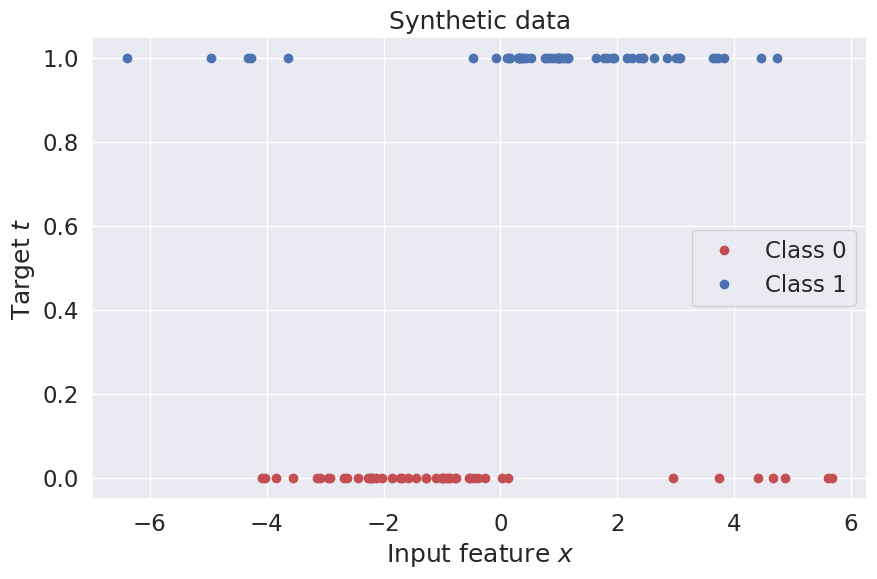

In [14]:
np.random.seed(0)

sigmoid = lambda x: 1./(1+np.exp(-x))
y = lambda x:  5*np.sin(0.75*x)

N = 100
X = np.random.normal(0, 2.5, size=N)[:, None]
t = np.random.binomial(1, sigmoid(y(X)))

# define points for prediction/plotting
Xp = np.linspace(-15, 15, 300)[:, None]

# plot data
def plot_data(ax, X, t, title="Synthetic data"):
    ax.plot(X[t==0], t[t==0], 'ro', label='Class 0')
    ax.plot(X[t==1], t[t==1], 'bo', label='Class 1')
    ax.legend()
    ax.set(xlabel='Input feature $x$', ylabel='Target $t$', title=title)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax, X, t)


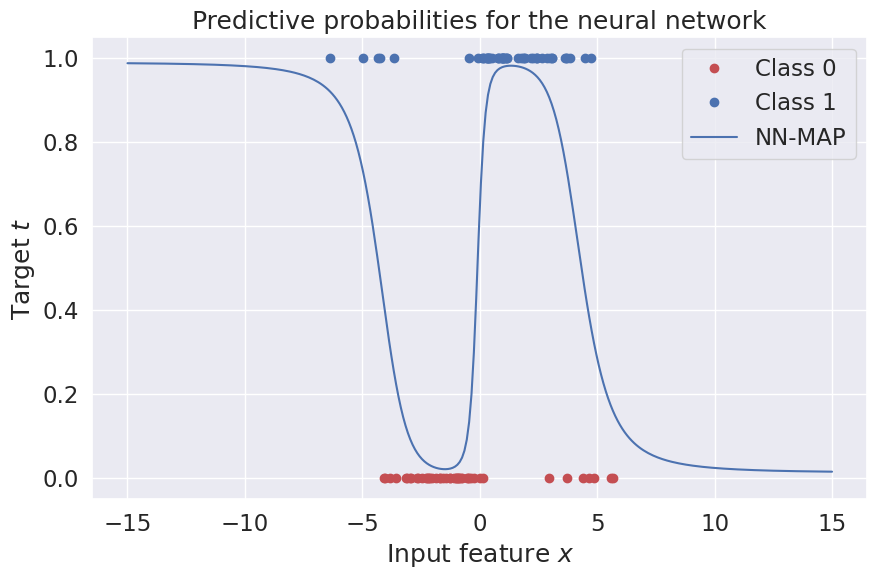

In [24]:
def log_lik_bernoulli(y, t): 
    """ implement log p(t=1|y) using the sigmoid inverse link function """
    p = sigmoid(y)
    return t.ravel()*np.log(p) + (1-t.ravel())*np.log(1-p)

# fit the NN model with 1 input dimension, 2 hidden layers of 20 neurons each, and 1 output
nn = NeuralNetworkMAP(X, t, [1, 20, 20, 1], alpha=1., log_lik_fun=log_lik_bernoulli)

# predict using neural network
y_nn = nn.predict(Xp)
p_nn = sigmoid(y_nn)

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax, X, t, title='Predictive probabilities for the neural network')
ax.plot(Xp, p_nn, label='NN-MAP')
ax.legend();

Next, we will fit a Gaussian process model using the squared exponential kernel and using the Laplace approximation for inference:

In [25]:
def compute_predictive_prob_MC(mu_y, Sigma_y, sample_size=2000):
    """
        The function computes p(t^* = 1|t, x^*) using Monte Carlo sampling  as in eq. (2).
        The function also returns the samples generated in the process for plotting purposes

        arguments:
        mu_y             -- N x 1 vector
        Sigma_y          -- N x N matrix
        sample_size      -- positive integer

        returns:
        p                -- N   vector
        y_samples        -- sample_size x N matrix
        sigma_samples    -- sample_size x N matrix

    """

    # generate samples from y ~ N(mu, Sigma)
    y_samples = generate_samples(mu_y, Sigma_y, sample_size).T 

    # apply inverse link function (elementwise)
    sigma_samples = sigmoid(y_samples)

    # return MC estimate, samples of y and sigma(y)
    return np.mean(sigma_samples, axis=0), y_samples, sigma_samples

# fit the GP model
kappa = 2.
scale = 1.
theta = [kappa, scale]
gp = GaussianProcessModel(X, t, theta, log_lik_bernoulli)

# compute distribution p(y^*|t) = N(y^*|mu_y, Sigma_y)
mu_y, Sigma_y = gp.compute_posterior_y(Xp, pointwise=False)
var_y = np.diag(Sigma_y)

# compute prediction distribution p(t^*|t, x^*)
p, y_samples, p_samples = compute_predictive_prob_MC(mu_y, Sigma_y)



**Questions**


1.1) Skim through the code of the classes *NeuralNetworkMAP* and *GaussianProcessModel* in the module *exercise5.py*



1.2) Complete the implementation of the function *compute_predictive_prob_MC* above.


The cell below plots and compares the neural network and Gaussian process model:

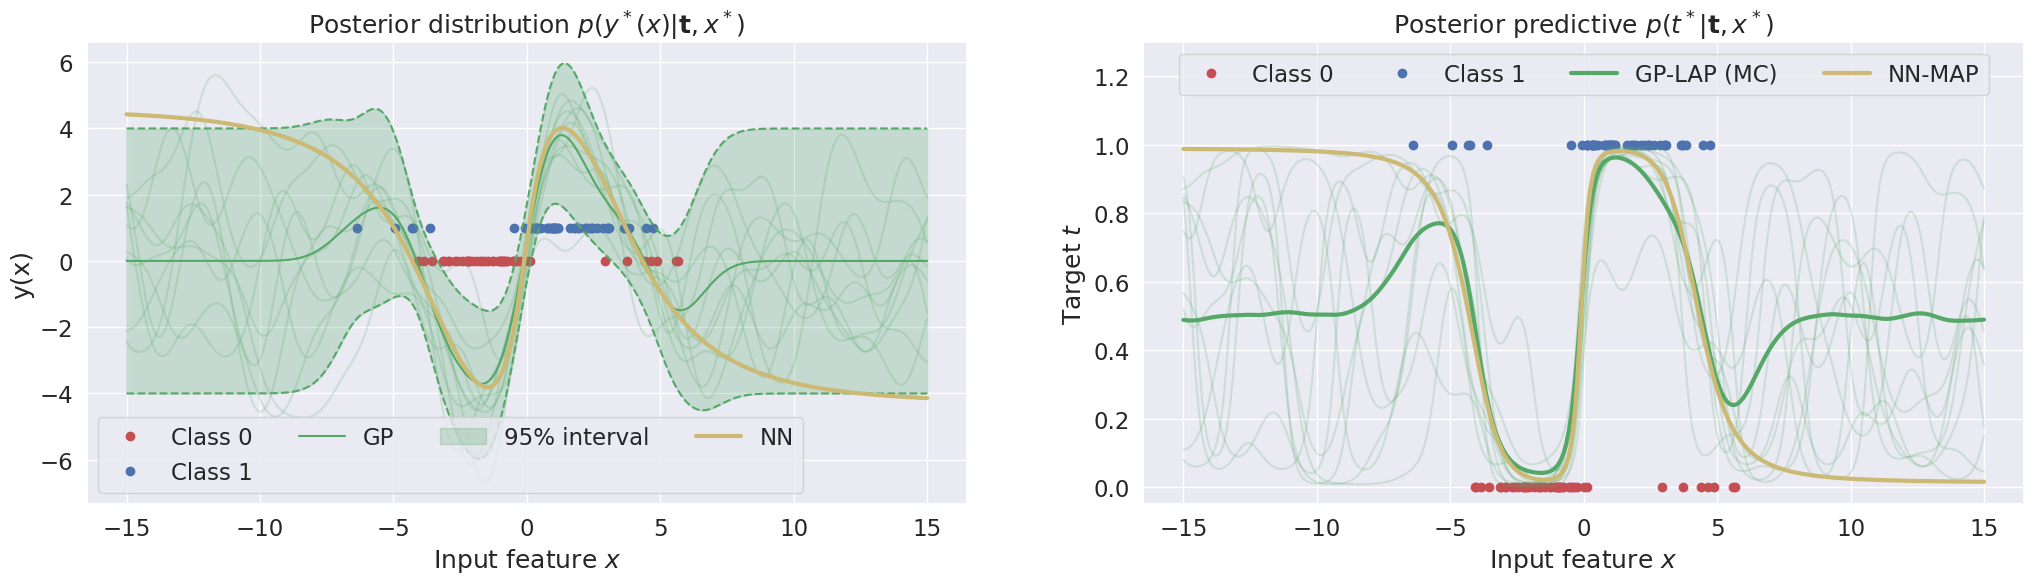

In [26]:
# solution for question 1.7)
phi = lambda x: norm.cdf(x)


# number of samples function to plot
num_samples_plot = 10

# plot
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
plot_data(ax[0], X, t)
plot_data(ax[1], X, t)

# plot posterior  p(y^*|t, x^*)
plot_with_uncertainty(ax[0], Xp, mu_y, Sigma_y, color='g', title='Posterior distribution $p(y^*(x)|\mathbf{t}, x^*)$')
ax[0].plot(Xp, y_samples[:num_samples_plot, :].T, color='g', alpha=0.2)
ax[0].plot(Xp, y_nn, 'y', linewidth=3, label='NN')
ax[0].legend(ncol=4)
ax[0].set_ylabel('y(x)')

# plot predictive distribution p(t^*|t, x^*)
ax[1].plot(Xp, p_samples[:num_samples_plot, :].T, color='g', alpha=0.2)
ax[1].plot(Xp, p, 'g-', linewidth=3, label='GP-LAP (MC)')
ax[1].plot(Xp, p_nn, 'y', linewidth=3, label='NN-MAP')
ax[1].set(ylim=(-0.05, 1.3), title='Posterior predictive $p(t^*|\mathbf{t}, x^*)$')
ax[1].legend(ncol=4, loc='upper center')


***Questions***


1.3) What is the relationship between the thin green lines on the left hand plot vs the right hand plot?
* Thin green lines to the left are the estimated functions y(x) and to the left they have been squeezed through the inverse link function $\sigma(\cdot)$ down to the unit interval.

1.4) What are the dimensions of the mean $\mathbf{m}$ and the covariance $\mathbf{S}$ of the Laplace approximation?
* The mean is an M dimensional vetor where M is the number of new x points we predict on.
* The covariance is NxN for our training points X

1.5) What does the values of the mean $\mathbf{m}$ in the Laplace approximation $q(\mathbf{y}) = \mathcal{N}(\mathbf{y}|\mathbf{m}, \mathbf{S})$ represent and how does it relate to the figures?
* The value of $\mathbf{m}$ is a N dimensional vector where each entry represents the mean function value evaluated a point $x_n$. This is the thick green line in the left plot and if we run it through the inverse link function $\sigma()$ we get the thick green line in the right plot.

*Hint*: If you are in doubt, plot the posterior mean vector *gp.m* vs. training data *X* on top of the left plot

1.6) Compare the predictive distribution for the neural network and the Gaussian process. How do they differ (qualitatively) within the support of the data?
 Outside the support of the data?
 * Within the support of the data they vary only a little. But outside the support of the data, the Gaussian process goes towards 0.5 i.e. completely uncertain about the class, when we go far away from the support of the data, where as neural network makes over confident predictions of either completely class 1 or 2.
 * Also within the support of the data class = 1 around x = -5 the Gaussian process still expresses a bit more uncertainty matching the fact, that we have few observations there.

 *Hint*: Increase the prediction range for $X_p$, e.g. from $\left[-6.5, 6.5\right]$ to $\left[-15, 15\right]$
 
1.7) Implement and plot the probit approximation in eq. (3) for the Gaussian process. 
#TODO

*Hint*: the function *norm.cdf* implements the cumulative distribution function for the standardized Gaussian distribution

1.8) What are the pros and cons for the probit approximation vs the Monte Carlo sampling?
* Pro probit: We have a closed form analytical solution
* Cons: Probit approximation of the sigmoid flattens out the distribution a bit and is more prone to instability from outliers than the sigmoid function.
    * Since the Monte Carlo Sampling uses the actual sigmoid function it becomes more robust to outliers. However it takes more time to due large sample sizes


1.9) The neural network model uses an isotropic Gaussian prior for all weights, i.e. $w_i \sim \mathcal{N}\left(0, \alpha^{-1}\right)$. What happens if you increase $\alpha$ from $1$ to e.g. $10$? Can you explain the result?
* The variance is reduced, so more probability mass will be around the mean 0 in the prior. This means that the prior will have very high probability when we increase $\alpha$ due to the reduced variance. The low variance giving high certainty in the prior will make the prior dominate the neural network prediction. This will push the NN prediction towards the prior mean i.e. class= 0 in this case.
*Hint*: Recall the relationship between Gaussian priors and regularization when using MAP estimates

### Part 2: Gaussian process classification for 2D data set

We will now use the MNIST data from week 3 to further study the properties of Gaussian process models.

The function in the cell below loads the MNIST data and projects the data to a 2-dimensional space using PCA as we did in week 3.

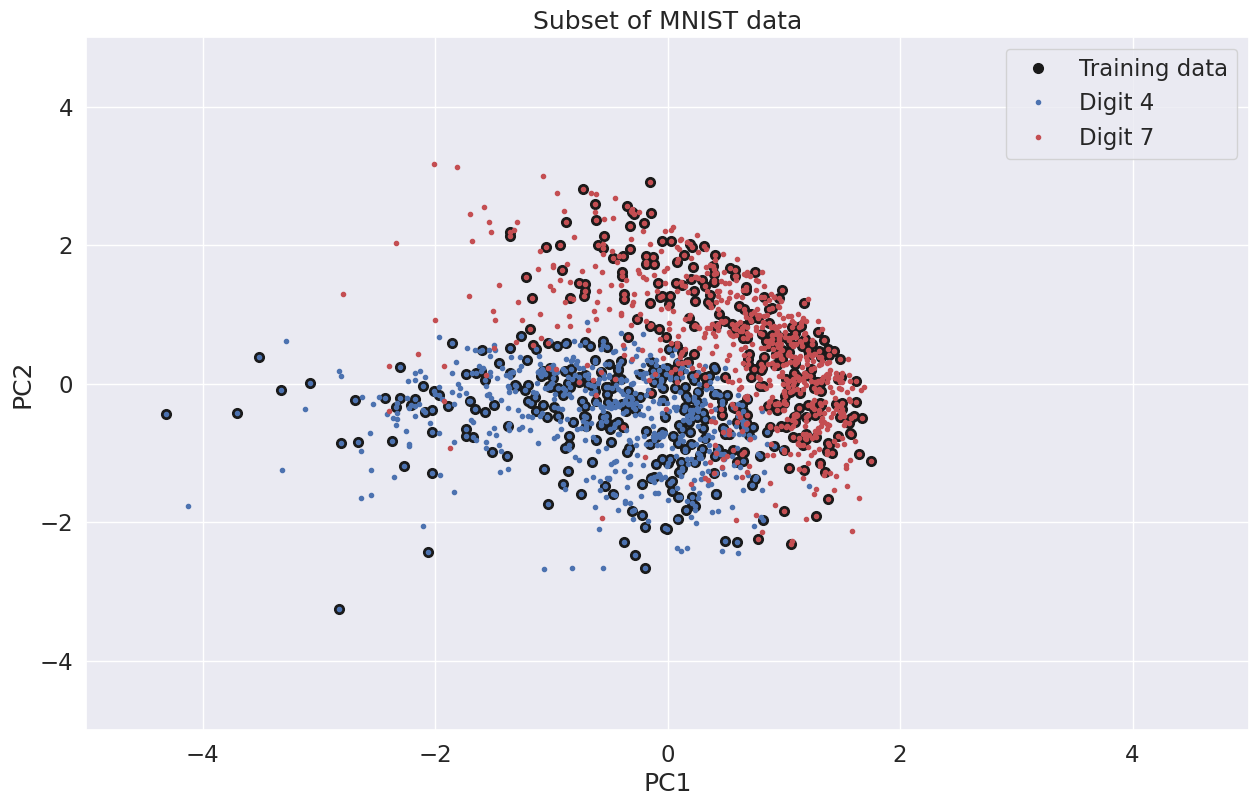

In [27]:
digits = [4, 7]
Xtrain, Xtest, ttrain, ttest = load_MNIST_subset('./mnist_subset.npz', digits=digits, subset=500)

# make sure dimensions are [N x 1]
ttrain = ttrain[:, None]
ttest = ttest[:, None]

X = np.row_stack((Xtrain, Xtest))
t = np.row_stack((ttrain, ttest))

# plot
def plot_data(ax, title="", xlim=(-5, 5), ylim=(-5, 5)):
    ax.plot(Xtrain[:, 0], Xtrain[:, 1], 'ko', markersize=7, label='Training data')
    ax.plot(X[t.ravel()==0, 0], X[t.ravel()==0, 1], 'b.', label='Digit %d' % digits[0])
    ax.plot(X[t.ravel()==1, 0], X[t.ravel()==1, 1], 'r.', label='Digit %d' % digits[1])
    ax.set_xlim((-5,5 ))
    ax.set_ylim((-5,5 ))
    ax.set(title=title, xlim=xlim, ylim=ylim, xlabel='PC1', ylabel='PC2')
    ax.legend()

fig, ax = plt.subplots(1,1, figsize=(15,9))
plot_data(ax, title='Subset of MNIST data')

Let's fit the Gaussian process

In [28]:
# Gaussian process
kappa = 1.
scale = 1.
theta = [kappa, scale]

gp = GaussianProcessModel(Xtrain, ttrain, theta, log_lik_bernoulli)

... and plot the result

Training error:	0.08 (0.01)
Test error:	0.08 (0.01)


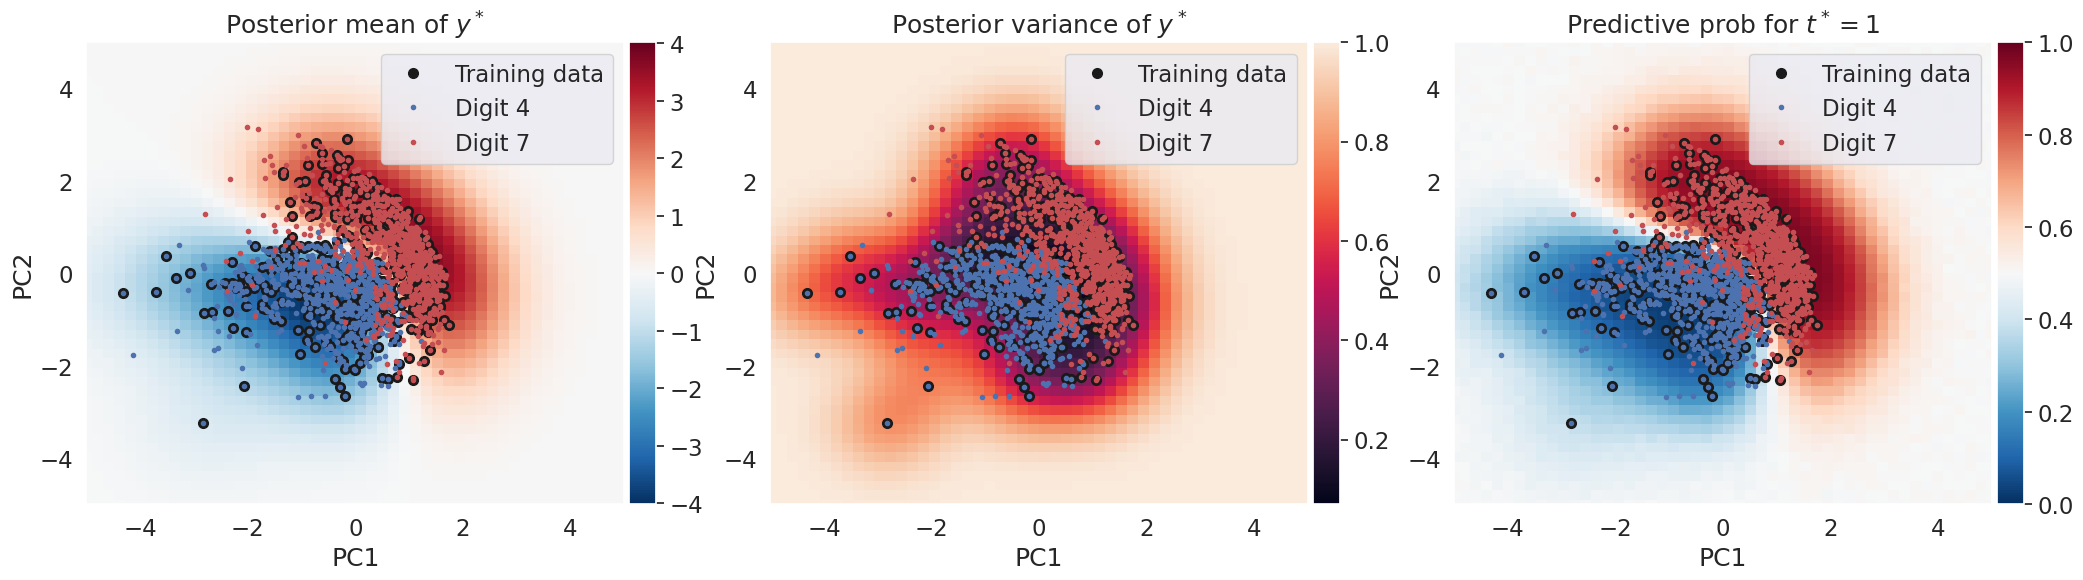

In [29]:
def predictive(Xp):
    mu_y, var_y = gp.compute_posterior_y(Xp, pointwise=True)
    p, _, _ = compute_predictive_prob_MC(mu_y, np.diag(var_y))
    return p

# predict
p_train = predictive(Xtrain)
p_test = predictive(Xtest)

# make predictions
ttrain_hat = 1.0*(p_train > 0.5)
ttest_hat = 1.0*(p_test > 0.5)

# print results: mean and standard error of the mean
print('Training error:\t%3.2f (%3.2f)' % compute_err(ttrain_hat.ravel(), ttrain.ravel()))
print('Test error:\t%3.2f (%3.2f)' % compute_err(ttest_hat.ravel(), ttest.ravel()))

# prepare for plotting
x_grid, posterior_y_gpc_eval_mu = eval_density_grid(lambda x: gp.compute_posterior_y(x)[0], P=50, )
x_grid, posterior_y_gpc_eval_var = eval_density_grid(lambda x: gp.compute_posterior_y(x)[1], P=50)
x_grid, posterior1_gpc_eval = eval_density_grid(predictive, P=50, a=-5, b=5)

# prepare plot
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

# plot posterior mean
im = ax[0].pcolormesh(x_grid, x_grid, posterior_y_gpc_eval_mu, cmap=plt.cm.RdBu_r, norm=colors.CenteredNorm(), shading='auto')
plot_data(ax[0], title="Posterior mean of $y^*$")
add_colorbar(im, fig, ax[0])

# plot posterior var
im = ax[1].pcolormesh(x_grid, x_grid, posterior_y_gpc_eval_var, shading='auto')
plot_data(ax[1], title="Posterior variance of $y^*$")
add_colorbar(im, fig, ax[1])

# plot posterior predictive
im = ax[2].pcolormesh(x_grid, x_grid, posterior1_gpc_eval, cmap=plt.cm.RdBu_r, shading='auto', clim=(0, 1))
plot_data(ax[2], title="Predictive prob for $t^* = 1$")
add_colorbar(im, fig, ax[2])



**Questions**

2.1) Explain what you see in the 3 panels - explain the difference between the two distributions $p(y(\mathbf{x})|\mathbf{t})$ and $p(t(\mathbf{x})|\mathbf{t})$
* In panel 1: We see the posterior mean evaluated in each grid point in the x_grid,x_grid color_mesh
* In panel 2: We see the posterior variance evaluated in each grid point in the x_grid,x_grid color_mesh
* In panel 3: We see the class predictions made by monte carlo sampling from the posterior and using the sigmoid function. The posterior has the mean and variance used in panel 1 and 2

2.2) What is the dimensionality of $\mathbf{m}$ and $\mathbf{S}$?

2.3) What does the values of mean $\mathbf{m}$ in the Laplace approximation $q(\mathbf{y}) = \mathcal{N}(\mathbf{y}|\mathbf{m}, \mathbf{S})$ represent and how does it relate to the figures?

2.4) Comment on the uncertainties within the support of the data and outside the data

2.5) Make the equivalent of the right most plot for the NN neural model below. Comment on the differences.

*Hint*: Remember to change the number of inputs in the neural network from 1 to 2

2.6) What is the training and test error for the neural network?


